Unlike the other packages, we suggest you to download the `deepcde` repository in your working directory:

In [87]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from deepcde.bases.cosine import CosineBasis
from deepcde.deepcde_pytorch import cde_layer, cde_loss, cde_predict
from deepcde.utils import box_transform

In [68]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

We first define the number of basis and the basys system (in this case cosine basis)

In [4]:
n_basis = 31
basis = CosineBasis(n_basis)

In the following cell we run the `wget` module to fetch the data from the [COINtoolbox Github repository](https://github.com/COINtoolbox/photoz_catalogues/tree/master/Teddy). <br>
You can download the Teddy A and B manually if you prefer.

In [5]:
import os
import wget

data_dir = 'data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print('"data" subfolder created')
    
_ = wget.download('https://github.com/COINtoolbox/photoz_catalogues/raw/master/Teddy/teddy_A', 
              out='data/teddy_A.txt')

_ = wget.download('https://github.com/COINtoolbox/photoz_catalogues/raw/master/Teddy/teddy_B', 
              out='data/teddy_B.txt')

The following lines assume you have the datasets `Teddy A` and `Teddy B` in a subfolder of your current directory. By default this subfolder is `data`, but it can be changed below. The following function extract the information from the .txt file and generates numpy array. <br> <br>

You can find the `Teddy A` and `Teddy B` dataset in the [COINtoolbox Github repository](https://github.com/COINtoolbox/photoz_catalogues/tree/master/Teddy).

In [6]:
def extract_teddy_data(filename, train_data, directory='data/'):
    
    full_data = []
    outfiles = ('teddy_x_train.npy', 'teddy_z_train.npy') if train_data else ('teddy_x_test.npy', 'teddy_z_test.npy')
    with open(filename) as fp:
        full_lines = fp.readlines()
        for line in full_lines:
            if '#' in line:
                continue
            full_data.append([float(el) for el in line.strip().split(' ') if el])
        fp.close()
    
    # Saving the formatted Teddy data
    np.save(arr=np.array(full_data)[:, 7:12], file=directory + outfiles[0])
    np.save(arr=np.array(full_data)[:, 6], file=directory + outfiles[1])
    print('Extraction and Saving Done!')

In [7]:
extract_teddy_data(filename='data/teddy_A.txt', train_data=True, directory='data/')

Extraction and Saving Done!


In [8]:
extract_teddy_data(filename='data/teddy_B.txt', train_data=False, directory='data/')

Extraction and Saving Done!


## Load Teddy Cosmology Data

The $\texttt{TEDDY}$ data are comprised of 4 datasets, generated by subsampling from the [SDSS DR12](https://www.sdss.org/dr12/). <br>
The 4 datasets are named respectively A, B, C and D.

We use dataset A for training and B for testing.<br>
Data in these two datasets share the same underlying distribution, so training-based algorithms do not need any further adjustments. <br>
For more information, consult the [TEDDY Github Repo](https://github.com/COINtoolbox/photoz_catalogues/tree/master/Teddy).

Both datasets have around 74,000 spectroscopic samples in it. <br>
We downsample both training and testing, including only the first 5,000 and 500 galaxies respectively. <br>
Here we also use a validation set of 500 galaxies, taken from the training set.

In [9]:
train_limit_points = 5000
test_limit_points = 500
valid_limit_points = 500

x_train = np.load(file='data/teddy_x_train.npy')[:train_limit_points, :]
x_validation = np.load(file='data/teddy_x_train.npy')[train_limit_points:train_limit_points + valid_limit_points, :]
x_test = np.load(file='data/teddy_x_test.npy')[:test_limit_points, :]

z_train = np.load(file='data/teddy_z_train.npy')[:train_limit_points]
z_validation = np.load(file='data/teddy_z_train.npy')[train_limit_points:train_limit_points + valid_limit_points]
z_test = np.load(file='data/teddy_z_test.npy')[:test_limit_points]

To help with training, we standardize the features, as well as transform the response to span between 0 and 1

In [10]:
mu_train = np.tile(np.average(x_train, axis=0), (x_train.shape[0], 1))
std_train = np.tile(np.std(x_train, axis=0), (x_train.shape[0], 1))
x_train = np.divide(x_train - mu_train, std_train)

In [11]:
x_validation = np.divide(x_validation - mu_train[:500,:], std_train[:500,:])

In evaluting the basis coefficients the first coefficient is always 1. <br>
We therefore exclude the first coefficient from the fitting, resulting in `n_basis - 1` coefficients being effectively trained. <br>
This is automatically accounted for in the CDE loss function.

In [12]:
z_train = box_transform(z_train, min(z_train), max(z_train))  # transform to a variable between 0 and 1
z_basis = basis.evaluate(z_train)[:, 1:]               # evaluate basis, remove first coefficient
z_basis = z_basis.astype(np.float32)

In [13]:
z_validation = box_transform(z_validation, min(z_train), max(z_train))  # transform to a variable between 0 and 1
z_validation_basis = basis.evaluate(z_validation)[:, 1:]               # evaluate basis, remove first coefficient
z_validation_basis = z_validation_basis.astype(np.float32)

## Running DeepCDE

We first pass the training data and validation data to `torch` Tensor and then assign to the GPU, if one is available.

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

x=torch.from_numpy(x_train.astype(np.float64)).type(torch.Tensor).to(device)
z=torch.from_numpy(z_basis.astype(np.float64)).type(torch.Tensor).to(device)

x_validation = torch.from_numpy(x_validation.astype(np.float64)).type(torch.Tensor).to(device)
z_validation_basis=torch.from_numpy(z_validation_basis.astype(np.float64)).type(torch.Tensor).to(device)

We define a dataset class which is compatible with `torch`

In [16]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,x,z):
        self.x = x
        self.z = z
        
    def __getitem__(self,index):
        return self.x[index], self.z[index]
    
    def __len__(self):
        return len(self.x)
    
    
batch_size = 128
dataset = Dataset(x,z)
train_load = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

Now we create our Deep Neural network. In this case we create a 3-level deep net. <br>
Regardless of how we have defined our network, we attach a CDE layer on the final layer to allow for CDE training.

In [17]:
class TeddyNet(nn.Module):
    def __init__(self, basis_size, marginal_beta=None):
        super(TeddyNet, self).__init__()
        
        self.l1 = nn.Linear(5, 32)
        self.l2 = nn.Linear(32, 64)
        self.l3 = nn.Linear(64, 32)
        self.cde = cde_layer(32, basis_size)    # CDE layer here
        
        # If we had some initial guess for the betas, we could include it here.
        if marginal_beta is not None:
            self.cde.linear.bias.data = torch.from_numpy(marginal_beta[1:]).type(torch.FloatTensor)

    def forward(self, x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        beta = self.cde(x)
        return beta

We then initialize the network, as well the loss function and optimizer

In [18]:
#marginal_beta = np.average(basis.evaluate(z_train), axis=0)
model = TeddyNet(basis_size=n_basis, marginal_beta=None)
custom_loss = cde_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Here we set the total epochs to 500, but we check the validation loss every 25 epochs to avoid overfitting. <br>
If the validation loss has worsened in the last 50 epochs, we stop the training.

In [88]:
n_epochs = 500
epoch_check = 25

loss_list = []
valid_loss_list = []

for epoch in range(n_epochs):
    model.train()
    for batch_idx, (x_batch, z_basis_batch) in enumerate(train_load):
        x_batch, z_basis_batch = x_batch.to(device), z_basis_batch.to(device)
        optimizer.zero_grad()
        beta_batch = model(x_batch)
        loss = custom_loss(beta_batch, z_basis_batch)
        
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item()) 
    
    if epoch % epoch_check == 0:
        beta_pred_val = model(x_validation)
        loss_valid = custom_loss(beta_pred_val, z_validation_basis).item()
        print('Epoch %d, Training Loss: %.3f, Validation Loss: %.3f' %(epoch, loss_list[-1], loss_valid))
        
        valid_loss_list.append(loss_valid)
        if len(valid_loss_list) > 2 and (valid_loss_list[-1] > valid_loss_list[-2]):
            break

Epoch 0, Training Loss: 0.041, Validation Loss: -0.720
Epoch 25, Training Loss: -0.877, Validation Loss: -1.481
Epoch 50, Training Loss: -2.074, Validation Loss: -2.419
Epoch 75, Training Loss: -3.380, Validation Loss: -3.433
Epoch 100, Training Loss: -4.246, Validation Loss: -4.042
Epoch 125, Training Loss: -4.794, Validation Loss: -4.421
Epoch 150, Training Loss: -5.281, Validation Loss: -4.703
Epoch 175, Training Loss: -5.776, Validation Loss: -4.943
Epoch 200, Training Loss: -6.287, Validation Loss: -5.157
Epoch 225, Training Loss: -6.793, Validation Loss: -5.344
Epoch 250, Training Loss: -7.290, Validation Loss: -5.502
Epoch 275, Training Loss: -7.752, Validation Loss: -5.627
Epoch 300, Training Loss: -8.170, Validation Loss: -5.722
Epoch 325, Training Loss: -8.538, Validation Loss: -5.790
Epoch 350, Training Loss: -8.871, Validation Loss: -5.835
Epoch 375, Training Loss: -9.167, Validation Loss: -5.859
Epoch 400, Training Loss: -9.424, Validation Loss: -5.868
Epoch 425, Training 

### Visualize Predicted CDEs

In calculating the output, we need to be mindful of the features standardization we have done as well as response normalization.

In [20]:
# Here we need to normalize the input (using the same mu and std for training, 
# so we need to be careful with dimensions)
x_test = np.divide(x_test - mu_train[:500,:], std_train[:500,:])
x_test = torch.from_numpy(x_test.astype(np.float64)).type(torch.Tensor).to(device)

n_grid = 1000
z_grid = np.linspace(0, 1, n_grid)  # Creating a grid over the density range
beta_prediction = model(x_test)
cde_test = cde_predict(model_output=beta_prediction.cpu().detach().numpy(), 
                       z_min=0, z_max=1, z_grid=z_grid, basis=basis)

# Renormalizing
z_grid_final = z_grid * (max(z_train) - min(z_train)) + min(z_train)

The estimated conditional densities are saved as numpy array and are normalized, i.e. they integrate to 1.

In [21]:
from scipy.integrate import simps

print(type(cde_test), cde_test.shape)

den_integral = simps(cde_test[0, :], x=z_grid_final)
print('Integral of the first density integrates to: %.2f' % den_integral)

(<type 'numpy.ndarray'>, (500, 1000))
Integral of the first density integrates to: 1.00


In [73]:
import numpy as np
from scipy.spatial import KDTree

def cde_loss(cde_estimates, z_grid, z_test):
    """
    Calculates conditional density estimation loss on holdout data

    @param cde_estimates: a numpy array where each row is a density
    estimate on z_grid
    @param z_grid: a numpy array of the grid points at which cde_estimates is evaluated
    @param z_test: a numpy array of the true z values corresponding to the rows of cde_estimates

    @returns The CDE loss (up to a constant) for the CDE estimator on
    the holdout data and the SE error
    """

    if len(z_test.shape) == 1:
        z_test = z_test.reshape(-1, 1)
    if len(z_grid.shape) == 1:
        z_grid = z_grid.reshape(-1, 1)

    n_obs, n_grid = cde_estimates.shape
    n_samples, feats_samples = z_test.shape
    n_grid_points, feats_grid = z_grid.shape

    if n_obs != n_samples:
        raise ValueError("Number of samples in CDEs should be the same as in z_test."
                         "Currently %s and %s." % (n_obs, n_samples))
    if n_grid != n_grid_points:
        raise ValueError("Number of grid points in CDEs should be the same as in z_grid."
                         "Currently %s and %s." % (n_grid, n_grid_points))

    if feats_samples != feats_grid:
        raise ValueError("Dimensionality of test points and grid points need to coincise."
                         "Currently %s and %s." % (feats_samples, feats_grid))

    z_min = np.min(z_grid, axis=0)
    z_max = np.max(z_grid, axis=0)
    z_delta = (z_max - z_min)/(n_grid_points-1)

    integrals = z_delta * np.sum(cde_estimates**2, axis=1)

    kdtree = KDTree(z_grid)
    nn_ids = np.array(
        [kdtree.query(z_test[ii, :])[1] for ii in range(n_samples)]).reshape(-1,)
    likeli = cde_estimates[(tuple(np.arange(n_samples)), tuple(nn_ids))]

    losses = integrals - 2 * likeli
    loss = np.mean(losses)
    se_error = np.std(losses, axis=0) / (n_obs ** 0.5)

    return loss, se_error


We can calculate the CDE loss function importing the function from the [`cdetools` package](https://github.com/tpospisi/cdetools).

In [74]:
#from cdetools.src.cdetools.cde_loss import cde_loss as cde_loss_np

cde_loss_val, std_cde_loss = cde_loss(cde_test, z_grid, z_test)
print('CDE Loss: %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))

CDE Loss: -0.73 \pm 0.04


We here visualize the first 12 CDEs

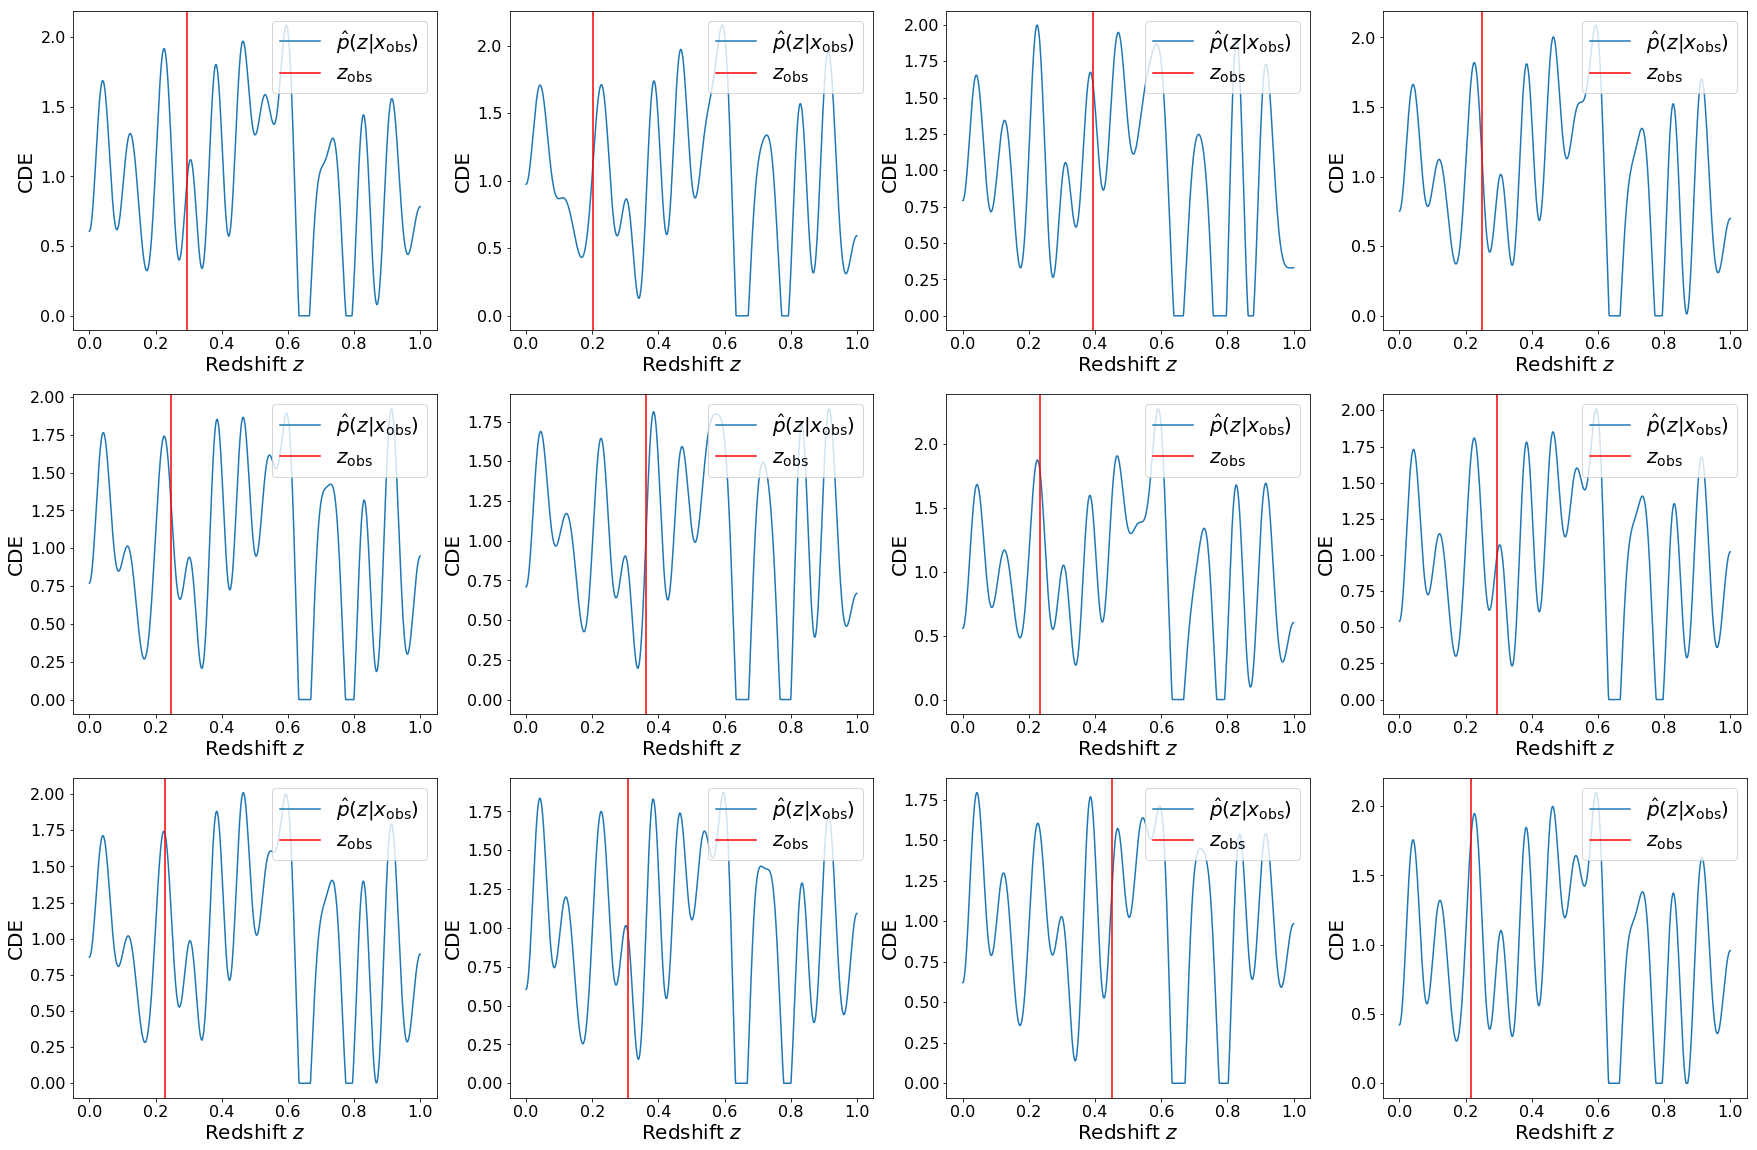

In [75]:
fig = plt.figure(figsize=(30, 20))
for jj, cde_predicted in enumerate(cde_test[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(z_grid, cde_predicted, label=r'$\hat{p}(z| x_{\rm obs})$')
    plt.axvline(z_test[jj], color='red', label=r'$z_{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'Redshift $z$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 20})
plt.show()

## CDE Diagnostics

We can compute the PIT and HPD values over our estimated CDEs. <br>
Functions to calculate both values can be found in the [`cdetools` package](https://github.com/tpospisi/cdetools).
<br>
We suggest to clone the Github repository and install it.

<code style="background:black;color:white">git clone https://github.com/tpospisi/cdetools.git </code> <br>
<code style="background:black;color:white">cd cdetools/python/ </code> <br>
<code style="background:black;color:white">python setup.py install </code> 

In [80]:
import numpy as np

def cdf_coverage(cdes, z_grid, z_test):
    """
    Calculates coverage based upon the CDF

    @param cdes: a numpy array of conditional density estimates;
        each row corresponds to an observation, each column corresponds to a grid
        point
    @param z_grid: a numpy array of the grid points at which cde_estimates is evaluated
    @param z_test: a numpy array of the true z values corresponding to the rows of cde_estimates

    @returns A numpy array of values
    """

    nrow_cde, ncol_cde = cdes.shape
    n_samples = z_test.shape[0]
    n_grid_points = z_grid.shape[0]

    if nrow_cde != n_samples:
        raise ValueError("Number of samples in CDEs should be the same as in z_test."
                         "Currently %s and %s." % (nrow_cde, n_samples))
    if ncol_cde != n_grid_points:
        raise ValueError("Number of grid points in CDEs should be the same as in z_grid."
                         "Currently %s and %s." % (nrow_cde, n_grid_points))

    z_min = np.min(z_grid)
    z_max = np.max(z_grid)
    z_delta = (z_max - z_min)/n_grid_points
    vals = [z_delta * np.sum(cdes[ii, np.where(z_grid > z_test[ii])[0]]) for ii in range(n_samples)]
    return np.array(vals)


In [81]:
import numpy as np


def _hpd_countour_level(prob_val, density, z_delta, n_grid,
                        max_iters=200, tol=1e-3):
    """
    Calculate contour levels for HPD sets, for a single level

    @param density: A vector of density evaluations.
    @param z_grid: The grid on which the density is evaluated. Should be
        regularly spaced.
    @param prob_val: The probability level for the HPD sets
    @param z_delta: shrinking factor for the density;
    @param n_grid: number of points in the grid for evaluating the density
    @param max_iters: Optional; number of iterations of binary search
    @param tol: Optional; tolerance of binary search
    """

    if max_iters <= 0:
        raise ValueError("Maximum Iterations needs to be positive."
                         "Currently %s" % (max_iters))
    lower = np.min(density)
    upper = np.max(density)

    for _ in range(max_iters):
        mid = (upper + lower) / 2
        area = np.sum(density[np.where(density >= mid)]) * z_delta / n_grid

        if np.abs(area - prob_val) < tol:
            return mid
        elif area < prob_val:
            upper = mid
        else:
            lower = mid

    return mid


def hpd_contour_levels(probs, density, z_grid, max_iters=200, tol=1e-3):
    """
    Calculate contour levels for HPD sets - wrapper for `_hpd_countour_level`

    @param density: A vector of density evaluations.
    @param z_grid: The grid on which the density is evaluated. Should be
        regularly spaced.
    @param probs: The probability levels for the HPD sets
    @param max_iters: Optional; number of iterations of binary search
    @param tol: Optional; tolerance of binary search
    """

    if max_iters <= 0:
        raise ValueError("Maximum Iterations needs to be positive."
                         "Currently %s" % (max_iters))

    z_min = np.min(z_grid, axis=0)
    z_max = np.max(z_grid, axis=0)
    z_delta = np.prod(z_max - z_min)
    n_grid = z_grid.shape[0]

    levels = np.apply_along_axis(func1d=_hpd_countour_level, axis=0,
                                 arr=probs, z_delta=z_delta, density=density,
                                 max_iters=max_iters, tol=tol, n_grid=n_grid)

    return levels

In [82]:
import numpy as np
from scipy.spatial import KDTree


def hpd_coverage(cdes, z_grid, z_test):
    """
    Calculate coverage based upon HPD regions.

    @param cdes: a numpy array of conditional density estimates;
        each row corresponds to an observation, each column corresponds to a grid
        point
    @param z_grid: a numpy array of the grid points at which cde_estimates is evaluated
    @param z_test: a numpy array of the true z values corresponding to the rows of cde_estimates

    @returns A numpy array of values; under the true generating model
       these are Uniform(0, 1)
    """

    if len(z_test.shape) == 1:
        z_test = z_test.reshape(-1, 1)
    if len(z_grid.shape) == 1:
        z_grid = z_grid.reshape(-1, 1)

    nrow_cde, ncol_cde = cdes.shape
    n_samples, feats_samples = z_test.shape
    n_grid_points, feats_grid = z_grid.shape

    if nrow_cde != n_samples:
        raise ValueError("Number of samples in CDEs should be the same as in z_test."
                         "Currently %s and %s." % (nrow_cde, n_samples))
    if ncol_cde != n_grid_points:
        raise ValueError("Number of grid points in CDEs should be the same as in z_grid."
                         "Currently %s and %s." % (nrow_cde, n_grid_points))

    if feats_samples != feats_grid:
        raise ValueError("Dimensionality of test points and grid points need to coincise."
                         "Currently %s and %s." % (feats_samples, feats_grid))

    z_min = np.min(z_grid, axis=0)
    z_max = np.max(z_grid, axis=0)
    z_delta = np.prod(z_max - z_min) / n_grid_points
    kdtree = KDTree(z_grid)

    vals = np.zeros((n_samples, ))
    for ii in range(n_samples):
        nn_id = kdtree.query(z_test[ii, :])[1]
        vals[ii] = z_delta * np.sum(cdes[ii, np.where(cdes[ii, :] > cdes[ii, nn_id])])

    return vals


In [83]:
from scipy.stats import binom
from matplotlib import pyplot as plt
import numpy as np

def plot_with_uniform_band(values, ci_level, x_label, n_bins=30, figsize=(10,4), ylim=[0, 50]):
    '''
    Plots the PIT/HPD histogram and calculates the confidence interval for the bin values, were the PIT/HPD values follow an uniform distribution

    @param values: a numpy array with PIT/HPD values
    @param ci_level: a float between 0 and 1 indicating the size of the confidence level
    @param x_label: a string, populates the x_label of the plot
    @param n_bins: an integer, the number of bins in the histogram
    @param figsize: a tuple, the plot size (width, height)
    @param ylim: a list of two elements, including the lower and upper limit for the y axis

    @returns The matplotlib figure object with the histogram of the PIT/HPD values and the CI for the uniform distribution
    '''

    # Extract the number of CDEs
    n = values.shape[0]

    # Creating upper and lower limit for selected uniform band
    ci_quantity = (1-ci_level)/2
    low_lim = binom.ppf(q=ci_quantity, n=n, p=1/n_bins)
    upp_lim = binom.ppf(q=ci_level + ci_quantity, n=n, p=1/n_bins)

    # Creating figure
    fig = plt.figure(figsize=figsize)
    plt.hist(values, bins=n_bins)
    plt.axhline(y=low_lim, color='grey')
    plt.axhline(y=upp_lim, color='grey')
    plt.axhline(y=n/n_bins, label='Uniform Average', color='red')
    plt.fill_between(x=np.linspace(0, 1, 100),
                     y1=np.repeat(low_lim, 100),
                     y2=np.repeat(upp_lim, 100),
                    color='grey', alpha=0.2)
    plt.legend(loc='best', prop={'size': 18})
    plt.xlabel(x_label, size=20)
    plt.ylim(ylim)
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.close()
    return fig



In [84]:


# Computing the values
z_grid = np.linspace(z_train.min(), z_train.max(), n_grid)
pit_values = cdf_coverage(cde_test, z_grid, z_test)
hpd_values = hpd_coverage(cde_test, z_grid, z_test)

Computing the number of values per each bin in the histogram under uniformity assumptions. <br>
We look at the 99% CI.

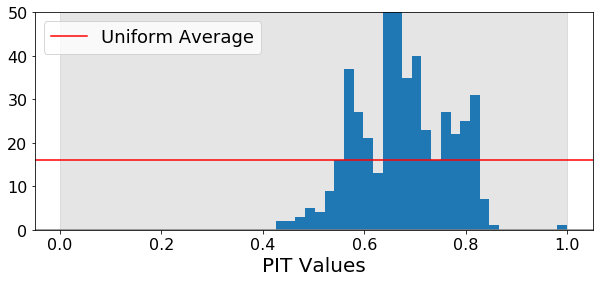

In [85]:
fig_pit = plot_with_uniform_band(values=pit_values, ci_level=0.99, x_label='PIT Values', n_bins=30)
fig_pit

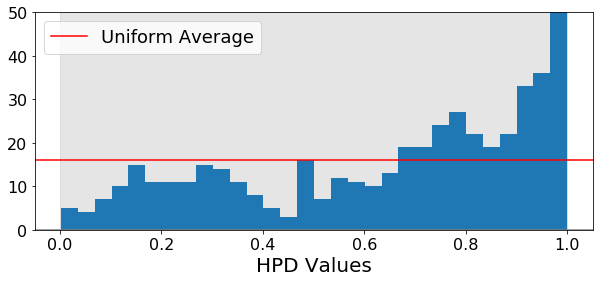

In [86]:
fig_hpd = plot_with_uniform_band(values=hpd_values, ci_level=0.99, x_label='HPD Values', n_bins=30)   
fig_hpd